# Week 5: Probability/Statistics, Bayes and Naive Bayes Classifiers

# Lecture 8: Crash Course in Probability and Statistics

Refer to the lecture notes for this content on probability and statistics necessary for ML.

In this lecture, we followed parts of Ch 2 and Ch 18.1 from [Data Mining and Machine Learning: Fundamental Concepts and Algorithms](https://dataminingbook.info/) by Zaki and Meira, Jr., as well as Dr. White's probability notes.

## Classification Problems

**Classification problems** are problems where we would like to take datapoints and assign them to an appropriate **class** based on some examples that have known classes.

### Examples

* If we have a dataset of medical records where each datapoint has a single patient's age, weight, blood pressure, status as a smoker or not, and other information and each patient is known to either have or not have kidney disease. We might want take data from a new patient and predict if he or she is likely to develop kidney disease.

* If we have a dataset of labeled images of cat and dogs, we might want to take a new image and classify whether it has a dog or a cat. (How does Google image search know how to find pictures of what you search?)

* If we have a dataset of audio files, each of which is a jazz, classical, rock, pop, or hip-hop song, we might want to predict the genre of a new audio file. (Spotify does this kind of analysis to recommend songs based on your listening history.)

* If we have a dataset of traffic logs on a network, some known to be infected by a specific virus and some are not, we might want to use this information to classify a new traffic log as likely to be infected or not.

* If we have a dataset of sounds of people speaking along with transcripts of the words, we might want to classify the words spoken into a microphone. (Think Siri!)

In all of these cases, the information can be represented as a point in the $n$-dimensional real space.

* The medical records would have numbers for age, weight, and blood pressure and a binary digit for non-smoker or smoker.

<img src="images/medicalRecords.png" />

* The dog/cat images might have three channels for a picture, meaning three numbers for each pixel (the red, green, and blue levels) like the bird picture below.

<img src="images/birdRGB.png" />

* The audio files might have numbers specifying the type of sound for the song many times per second.

<img src="images/audioFile.png" />

* The network traffic logs might have numbers of packets transferred, file size, ports, addresses, the content of the packets, etc.

I chose these applications to demonstrate two things: (1) classification problems are interesting and useful in almost every area of study and (2) a huge class of classification problems have much in common mathematically. All apply to datapoints, although some types of data may have far more dimensions than others--a medical record may only have 10 to 12 numbers, but a 12-megapixel photo from the latest iPhone would have $4,000\times 3,000\times 3=36,000,000$ numbers, 3 for each pixel).

### The Math of a Classification Problem

To exploit the similarities, let's abstract away the specifics of the applications for now and think about how to describe a classification problem mathematically. Consider a $d$-dimensional point, or vector, $x\in\mathbb{R}^d$. $x$ is a member one of $k$ classes $C=\{c_1, c_2, ..., c_k\}$. We call the point $x$ an **example** and we call the class the **label** of $x$.

The goal of a classification problem is to find a function $M:\mathbb{R}^d\to C$ mapping each example $x$ to its class $y=M(x_1)$ and will generalize to successfully classify new, unlabeled datapoints with high accuracy.

This will segment the space $\mathbb{R}^d$ into sets $X_j=\{x_1\in\mathbb{R}^d | M(x_1)=c_j\}$ corresponding to each class. In the image below, for example, the space $\mathbb{R}^2$ is partitioned into three sets colored red, blue, and green.

<img src="images/knnTessellation.png" />
The colored points are labeled examples and the $\mathbb{R}^2$ space is colored by the class to be assigned to points in different regions. (image from Wikipedia)

### Classification Algorithms

There are many algorithms used for classification. Some of the most popular include

* Bayes and naive Bayes
* $k$-nearest neighbors
* decision trees
* logistic regression
* support vector machines
* neural networks (many types)

as well as tree-based algorithms that systematically apply an ensemble of different classifiers. Any of the methods above are good choices and there are pros and cons of each, but we only consider the Bayes classifiers this week.

# Lecture 9: The Bayes Classifier

## Bayes Classifer

Now that we covered the ideas of how the Bayes classifier works in class, we can now implement it, but let's first import some libraries.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sn

from scipy.stats import multivariate_normal
from sklearn import datasets
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import scipy
from tensorflow.keras.datasets import mnist

# increase the width of boxes in the notebook file (this is only cosmetic)
np.set_printoptions(linewidth=180)

Next, we write a class for the classifier.

In [2]:
class BayesClassifier:
    def fit(self, X, Y):     
        # find the unique labels
        uniqueY = np.unique(Y)
        
        # find the dimensions
        n = X.shape[0]
        self.d = X.shape[1]
        self.k = uniqueY.shape[0]
        
        # initialize the outputs
        self.prior = np.zeros([self.k, 1])
        self.mu = np.zeros([self.k, self.d])
        self.Sigma = np.zeros([self.k, self.d, self.d])
        
        # compute class prior probabilities, sample means, and sample covariances
        for i, y in enumerate(uniqueY):
            # split the X into its classes
            Xi = X[Y == y]
            
            # compute the size of each class
            ni = Xi.shape[0]
            
            # compute the priors
            self.prior[i] = ni / n
            
            # compute the sample mean
            self.mu[i] = np.mean(Xi, axis = 0)
            
            # compute the centered data
            XiBar = Xi - self.mu[i]
            
            # compute the sample covariance
            self.Sigma[i] = (1/ni) * XiBar.T @ XiBar
            
    def predict(self, X):
        n = X.shape[0]
        
        posteriorPre = np.zeros([n, self.k])
        
        # compute the pdf term of the posterior probabilities
        for i in range(n):
            for j in range(self.k):
                posteriorPre[i][j] = scipy.stats.multivariate_normal.pdf(X[i], self.mu[j], self.Sigma[j], allow_singular = True)
                
        # compute a vector proportional to the posterior probabilities
        posterior = posteriorPre * self.prior.T

        # find the label for each datapoint by choosing the most probable class
        predictions = np.argmax(posterior, axis = 1)
        
        return predictions

### Example: Classifying Irises

In [3]:
iris = datasets.load_iris()
print(iris['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========


Predicted class labels:
 [2 2 2 0 2 2 2 1 1 0 0 2 2 1 0 1 0 2 0 2 0 0 1 1 1 2 2 0 2 2 2 0 0 2 0 2 1 2]

True class labels:
 [2 2 2 0 2 2 2 1 1 0 0 2 2 1 0 1 0 2 0 2 0 0 1 1 1 2 2 0 2 2 2 0 0 2 0 2 1 2]

Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00        12
           1       1.00      1.00      1.00         8
           2       1.00      1.00      1.00        18

    accuracy                           1.00        38
   macro avg       1.00      1.00      1.00        38
weighted avg       1.00      1.00      1.00        38


Confusion Matrix:



<AxesSubplot:>

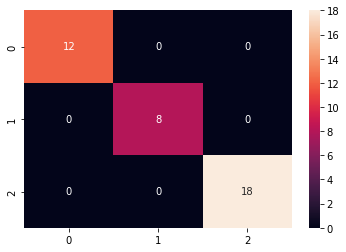

In [4]:
iris = datasets.load_iris()

#print(iris.target_names)

# find the data and labels
X = iris.data
Y = iris.target

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the Bayes classifier
model = BayesClassifier()

# fit the Bayes classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print predicted and true class labels
print('\nPredicted class labels:\n', predictedY)
print('\nTrue class labels:\n', testY)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

### Example: Detecting Breast Cancer

In [5]:
breastcancer = datasets.load_breast_cancer()
print(breastcancer['DESCR'])

.. _breast_cancer_dataset:

Breast cancer wisconsin (diagnostic) dataset
--------------------------------------------

**Data Set Characteristics:**

    :Number of Instances: 569

    :Number of Attributes: 30 numeric, predictive attributes and the class

    :Attribute Information:
        - radius (mean of distances from center to points on the perimeter)
        - texture (standard deviation of gray-scale values)
        - perimeter
        - area
        - smoothness (local variation in radius lengths)
        - compactness (perimeter^2 / area - 1.0)
        - concavity (severity of concave portions of the contour)
        - concave points (number of concave portions of the contour)
        - symmetry
        - fractal dimension ("coastline approximation" - 1)

        The mean, standard error, and "worst" or largest (mean of the three
        worst/largest values) of these features were computed for each image,
        resulting in 30 features.  For instance, field 0 is Mean Radi


Classification Report:

               precision    recall  f1-score   support

           0       0.98      0.82      0.89        50
           1       0.91      0.99      0.95        93

    accuracy                           0.93       143
   macro avg       0.94      0.90      0.92       143
weighted avg       0.93      0.93      0.93       143


Confusion Matrix:



<AxesSubplot:>

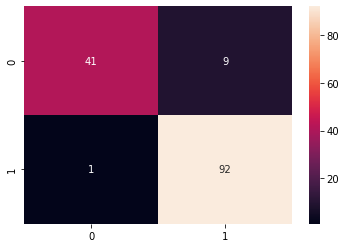

In [6]:
breastcancer = datasets.load_breast_cancer()

# find the data and labels
X = breastcancer.data
Y = breastcancer.target

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the Bayes classifier
model = BayesClassifier()

# fit the Bayes classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

## Example: Handwritten Digits

The Modified National Institute of Standards and Technology (MNIST) database contains 70,000 grayscale labeled images (each 28-by-28 pixels) of handwritten digits from US Census Bureau employees and high school students. Classifying the MNIST database is a common benchmark for machine learning techniques.

<img src='images/mnist.png' />

MNIST along with many other commonly-used datasets are available in the <a href="https://www.tensorflow.org/api_docs/python/tf/keras/datasets">tensorflow.keras.datasets</a> module. The first time you use the load_data() function, it will download the dataset, but any subsequent runs will just read it from the hard drive, if it has been downloaded before, so it runs much faster.

In [7]:
# load the MNIST data
from tensorflow.keras.datasets import mnist
mnistData = mnist.load_data()

Let's take a look at the data (press 'q' to iterate to the next image).

The label is 4
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 189 190   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 143 247 153   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 136 247 242  86   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0 192 252 187   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  62 185  18   0

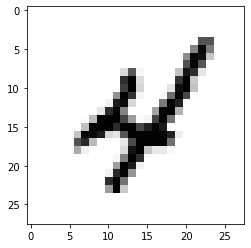

In [8]:
# DISPLAY MNIST PICTURES, DATA ARRAYS, AND LABELS
from IPython.display import clear_output
from keyboard import wait

for counter in range(10):
    # loop over the picture data
    pictureData = mnistData[0][0][counter]

    # plot the datapoints and their labels
    print('The label is', mnistData[0][1][counter])
    print(pictureData)

    # plot the image
    plt.imshow(pictureData, cmap='Greys')
    plt.show()
    
    # wait until user presses 'q'
    wait('q')
    
    # clear the input
    clear_output(wait=True)

In [9]:
# Let's check the shape of the pictureData
pictureData.shape

(28, 28)

Let's now see if we can train the Bayes classifier to classify the digits.


Classification Report:

               precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      0.93      0.96        14
           2       0.47      1.00      0.64         8
           3       0.50      0.55      0.52        11
           4       0.67      0.86      0.75        14
           5       1.00      0.57      0.73         7
           6       1.00      0.70      0.82        10
           7       0.79      1.00      0.88        15
           8       1.00      0.50      0.67         2
           9       1.00      0.09      0.17        11

    accuracy                           0.75       100
   macro avg       0.84      0.72      0.71       100
weighted avg       0.82      0.75      0.73       100


Confusion Matrix:



<AxesSubplot:>

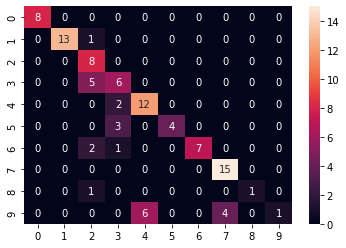

In [11]:
(trainX, trainY), (testX, testY) = mnist.load_data()

# flatten the data into 768-vectors
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2]).astype('float')/255.0
testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2]).astype('float')/255.0

# take only 100 images for the test set
testX = testX[:100]
testY = testY[:100]

# build the Bayes classifier
model = BayesClassifier()

# fit the Bayes classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

This code runs incredibly slowly, so we limited it to 100 test points.

## The Naive Bayes Classifier

The code above runs very slowly, so a modified version that assumes the data columns are independent is the naive Bayes classifier. While the assumption is typically not quite true of datasets, it tends to often work well in practice nevertheless, and provides a vast speed improvement.

In [12]:
# importing the scikit-learn implementation of the naive Bayes classifier
from sklearn.naive_bayes import GaussianNB

### Breast Cancer Example


Classification Report:

               precision    recall  f1-score   support

           0       0.96      0.84      0.89        61
           1       0.89      0.98      0.93        82

    accuracy                           0.92       143
   macro avg       0.93      0.91      0.91       143
weighted avg       0.92      0.92      0.92       143


Confusion Matrix:



<AxesSubplot:>

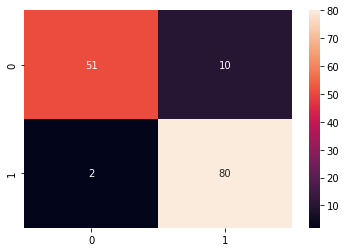

In [13]:
breastcancer = datasets.load_breast_cancer()

# find the data and labels
X = breastcancer.data
Y = breastcancer.target

# split the data into train and test sets
trainX, testX, trainY, testY = train_test_split(X, Y, test_size = 0.25)

# build the Bayes classifier
model = GaussianNB()

# fit the Bayes classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY), annot = True)

### Classifying MNIST Handwritten Digits with Naive Bayes


Classification Report:

               precision    recall  f1-score   support

           0       0.92      0.92      0.92       980
           1       0.86      0.96      0.91      1135
           2       0.90      0.73      0.80      1032
           3       0.82      0.78      0.79      1010
           4       0.85      0.61      0.71       982
           5       0.86      0.61      0.72       892
           6       0.83      0.92      0.87       958
           7       0.93      0.79      0.86      1028
           8       0.63      0.76      0.69       974
           9       0.60      0.90      0.72      1009

    accuracy                           0.80     10000
   macro avg       0.82      0.80      0.80     10000
weighted avg       0.82      0.80      0.80     10000


Confusion Matrix:



<AxesSubplot:>

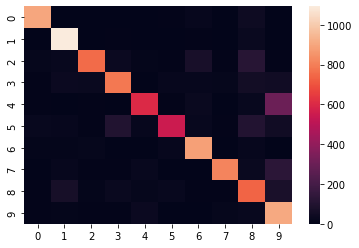

In [14]:
(trainX, trainY), (testX, testY) = mnist.load_data()

# flatten the data into 768-vectors and normalize
trainX = trainX.reshape(trainX.shape[0], trainX.shape[1] * trainX.shape[2]).astype('float')/255.0
testX = testX.reshape(testX.shape[0], testX.shape[1] * testX.shape[2]).astype('float')/255.0

# add some noise to the data
trainNoise = np.random.uniform(-0.1, 0.1, size = trainX.shape)
trainX += trainNoise

# build the Bayes classifier
model = GaussianNB()

# fit the Bayes classifier to the training data
model.fit(trainX, trainY)

# predict the labels of the test set
predictedY = model.predict(testX)

# print quality metrics
print('\nClassification Report:\n\n', classification_report(testY, predictedY))
print('\nConfusion Matrix:\n')

sn.heatmap(confusion_matrix(testY, predictedY))